# Laboratorio 8 - Deep Q-Network
Francisco Castillo - 21562
Diego Lemus - 21

In [23]:
import random
import numpy as np
import torch

SEED = 21562

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [24]:
import gymnasium as gym

env = gym.make('CartPole-v1')
env.reset(seed=SEED)
env.action_space.seed(SEED)
print(env)

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>


In [25]:
import torch.nn as nn

class QNetwork(nn.Module):
    def __init__(self, observation_space, action_space, hidden_size=128):
        super().__init__()
        input_size = observation_space.shape[0]
        output_size = action_space.n

        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.network(x)


In [26]:
import random
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        transition = (state, action, reward, next_state, done)
        self.buffer.append(transition)

    def sample(self, batch_size):
        if len(self.buffer) < batch_size:
            return []
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones


In [27]:
import torch.optim as optim
import numpy as np

class DQNAgent:
    def __init__(self, observation_space, action_space, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=1000, lr=0.001, hidden_size=128, device='cpu'):
        self.action_space_n = action_space.n
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.device = device

        self.q_network = QNetwork(observation_space, action_space, hidden_size).to(device)
        self.target_network = QNetwork(observation_space, action_space, hidden_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        self.steps_done = 0

    def select_action(self, state):
        epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                  np.exp(-1. * self.steps_done / self.epsilon_decay)
        self.steps_done += 1

        if random.random() > epsilon:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.q_network(state_tensor)
                action = q_values.argmax().item()
        else:
            action = random.randrange(self.action_space_n)
        return action

    def train(self, batch):
        if not batch:
            return

        states, actions, rewards, next_states, dones = batch

        states_tensor = torch.FloatTensor(states).to(self.device)
        actions_tensor = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states_tensor = torch.FloatTensor(next_states).to(self.device)
        dones_tensor = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        current_q_values = self.q_network(states_tensor).gather(1, actions_tensor)

        with torch.no_grad():
            next_q_values = self.target_network(next_states_tensor).max(1)[0].unsqueeze(1)
            target_q_values = rewards_tensor + self.gamma * next_q_values * (1 - dones_tensor)

        loss = self.criterion(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()


    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

In [28]:
num_episodes = 1000
batch_size = 64
target_update_freq = 10
train_freq = 4
replay_buffer_capacity = 10000

agent = DQNAgent(env.observation_space, env.action_space)
replay_buffer = ReplayBuffer(replay_buffer_capacity)

episode_rewards = []

for episode in range(num_episodes):
    state, info = env.reset()
    total_reward = 0
    done = False
    step = 0

    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        replay_buffer.add(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward
        step += 1

        if len(replay_buffer.buffer) > batch_size and step % train_freq == 0:
            batch = replay_buffer.sample(batch_size)
            agent.train(batch)

    episode_rewards.append(total_reward)

    if episode % target_update_freq == 0:
        agent.update_target_network()

    if (episode + 1) % 50 == 0:
        print(f'Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}')

print("Training finished.")

C:\Users\casti\AppData\Local\Temp\ipykernel_23316\688519607.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  states_tensor = torch.FloatTensor(states).to(self.device)


Episode 50/500, Total Reward: 19.0
Episode 100/500, Total Reward: 46.0
Episode 150/500, Total Reward: 305.0
Episode 200/500, Total Reward: 213.0
Episode 250/500, Total Reward: 142.0
Episode 300/500, Total Reward: 281.0
Episode 350/500, Total Reward: 231.0
Episode 400/500, Total Reward: 181.0
Episode 450/500, Total Reward: 173.0
Episode 500/500, Total Reward: 177.0
Training finished.


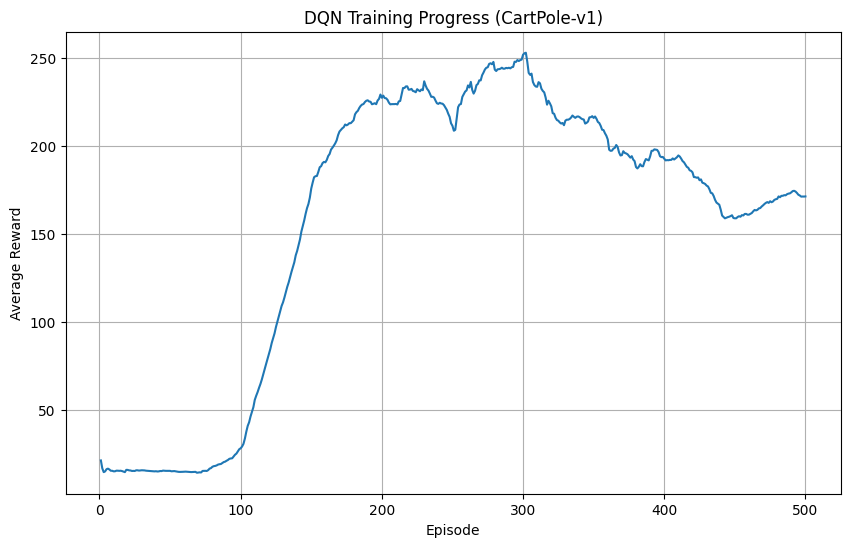

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

window_size = 50
rolling_avg = [np.mean(episode_rewards[max(0, i-window_size+1):i+1]) for i in range(len(episode_rewards))]

ax.plot(range(1, len(episode_rewards) + 1), rolling_avg)
ax.set_xlabel('Episode')
ax.set_ylabel('Average Reward')
ax.set_title('DQN Training Progress (CartPole-v1)')
ax.grid(True)
plt.show()

In [30]:
MODEL_PATH = 'model/dqn_cartpole.pth'

In [31]:
torch.save(agent.q_network.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to model/dqn_cartpole.pth


In [32]:
# Evaluate the trained agent without exploration
print("\nEvaluating trained agent...")

state, info = env.reset()
total_reward = 0
done = False

# Temporarily set epsilon to 0 for evaluation
original_epsilon_start = agent.epsilon_start
original_epsilon_end = agent.epsilon_end
agent.epsilon_start = 0
agent.epsilon_end = 0

while not done:
    action = agent.select_action(state) # select_action will now always choose the greedy action
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    state = next_state
    total_reward += reward

# Restore original epsilon values
agent.epsilon_start = original_epsilon_start
agent.epsilon_end = original_epsilon_end

print(f"Evaluation finished. Total Reward: {total_reward}")


Evaluating trained agent...
Evaluation finished. Total Reward: 259.0


In [33]:
# import os
# import time
# import torch
# import gymnasium as gym
#
# # Use existing MODEL_PATH if defined, otherwise default
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
#
# if not os.path.exists(MODEL_PATH):
#     raise FileNotFoundError(f'Model file not found at {MODEL_PATH}')
#
# # Recreate agent for inference and load weights
# inference_agent = DQNAgent(env.observation_space, env.action_space, device=device)
# state_dict = torch.load(MODEL_PATH, map_location=device)
# inference_agent.q_network.load_state_dict(state_dict)
# inference_agent.target_network.load_state_dict(inference_agent.q_network.state_dict())
# inference_agent.q_network.eval()
# inference_agent.target_network.eval()
#
# # Create a separate env with rendering enabled
# render_env = gym.make('CartPole-v1', render_mode='human')
#
# # Disable exploration
# orig_eps_start, orig_eps_end = inference_agent.epsilon_start, inference_agent.epsilon_end
# inference_agent.epsilon_start, inference_agent.epsilon_end = 0.0, 0.0
#
# try:
#     for run in range(1, 6):
#         state, info = render_env.reset(seed=SEED + run if 'SEED' in globals() else None)
#         done = False
#         total_reward = 0.0
#
#         while not done:
#             action = inference_agent.select_action(state)
#             next_state, reward, terminated, truncated, info = render_env.step(action)
#             done = terminated or truncated
#             state = next_state
#             total_reward += reward
#
#             render_env.render()
#             time.sleep(0.01)
#
#         print(f'Run {run}/5 - Total Reward: {total_reward}')
# finally:
#     inference_agent.epsilon_start, inference_agent.epsilon_end = orig_eps_start, orig_eps_end
#     render_env.close()
